
# Google Play Store Rating Prediction using Machine Learning

### Charley Zhao, Raymond Li

**Overview:**

This project explores the domain problem of how a Google Play Store app's rating can be predicted from a selection of other app attributes.

The type of machine learning task that this project delves into is supervised regression. As a result, the algorithms that we explore are as follows: Linear Regression, Lasso, and Ridge.

**Our findings:**

Based on our data cleaning and feature engineering (described below), the Ridge model mildly outperforms the basic Linear Regression model and Lasso model in predicting rating. 

This data set includes information regarding almost 10,000 applications on the google play store. It includes columns such as category, rating, number of reviews, size, etc. It was taken from the kaggle website on this link： https://www.kaggle.com/lava18/google-play-store-apps#googleplaystore.csv

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Below is the data as it appears in the original csv file.

In [0]:
#don't forget to upload googleplaystore.csv and googleplaystore_user_reviews.csv on the left
#final cleaned dataframe is "google5"
google1 = pd.read_csv("googleplaystore.csv")
google1.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [0]:
google1.isna().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

### 1. Preprocessing

**tl;dr of our data cleaning process:**
1. Size - convered to units of MB
2. Category, Type, Content Rating, #Installs are convered to one hot encoding
3. Genre, Last Update, Current Version, Android Version columns deleted
4. Missing Rating values replaced with average rating
5. Missing values of any other used column result in that whole row being deleted

When we view the first few lines of the data set, there are many things to note.

First, the App and Category names may displayed weird syntaxically. But it is displayed consistently, so there is no need for a renaming scheme. The categories column, however, should be one hot encoded since it is a categorical attribute. 

The size column will be have a renaming structure- we will drop the M, T, etc after the number and instead return the actual number written out. We assume "M" is the scraper's representation of "MB" when scraping from an older version of the google play store. However, we did find it weird we couldn't find any apps in the gigabytes from scrolling through the dataset. We will use a python function to search for this and replace each value with number*1000 if that is the case. Also, according to the kaggle link, 16% of rows have a "varies with device" output for this column. We will replace those with the average size of all the apps.

The number of installs is weird as it gives an approximate x+ rather than an exact number. Since the numbers are not linear (ie: categories are 1000+, 10000+, 50000+, 100000+, etc rather than sticking to constant intervals) we've decided it's best do to one hot encoding for this as well and treat it as categorical data.

The type and price columns are similar. Because the sample size for each individual dollar amount above 0 is very low, we would rather just compare free/paid then study the change in predicted rating for each dollar increase in price. Therefore, we will get rid of the "price" column. We will remove the "genres" column, as it is the same thing as the category column.

Content rating will also be done with one hot encoding.

Regarding the last three columns, latest update, current version, and android version, we initially thought that may give us an insight on how the app lifecycle can influence its ratings. However there were a few flaws with these columns. First, among these three columns, there were way too many rows with the value "varies with device"; this is not a quantitative data piece that can be substituted with something. In addition, we don't know the date this data set was scraped (it is based on an android iteration from years ago), so it is meaningless to try to associate any date or version of the apps to a point in the app's lifecycle. Because of this, we decided to drop the last three columns as well.

Last, we observe there are many rows with nil values. The ratings can be replaced with the average rating of every app. The row with missing "type" and "content rating" values will be removed. And the rows with missing "current version" and "android version" will remain as we are not using those columns anyway.

In [0]:
len(google1)

10841

In [0]:
google2 = google1.dropna(axis=0, subset=['Type', 'Content Rating'])
google3 = google2.rename(columns={"Content Rating": "Content_Rating"})
google3 = google3.drop(google3[google3.Content_Rating == 'Unrated'].index) #elimated the two unknown content ratings
len(google3)
# asserting the two rows with nil values were dropped (four values dropped in total)

10837

In [0]:
a = len(google3.groupby('Category').size()) #number of genre categories
b = len(google3.groupby('Installs').size()) #number of install number groups
c = len(google3.groupby('Content_Rating').size()) #number of content rating categories
(a, b, c)

(33, 20, 5)

In [0]:
google3.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content_Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Here we keep the relevant features.

In [0]:
google4 = google3.drop(['Genres', 'Last Updated', 'Current Ver', 'Android Ver', 'Price'], axis=1)
google4.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Content_Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,Everyone


Checking that there are no apps with a size in the gigabytes.

In [0]:
def check_g(s):
  if 'g' in s or 'G' in s:
    return 1
  return 0
google4["giga_check"] = google4["Size"].apply(lambda x: check_g(x))
google4.sum(axis = 0, skipna = True)[8]
#there are no sizes in the gigabytes (so no need to multiply any value by 1000)

0

In [0]:
google4 = google4.drop(['giga_check'], axis=1)

In [0]:
google4.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Content_Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,Everyone


Converting size from a string to float and replacing null values with the average.

In [0]:
def convert_size1(s):
    if s != 'Varies with device':
      result_string = ''
      *_, unit = s
      for digit in _:
        result_string = result_string + digit
      return float(result_string)

google4["Size1"] = google4["Size"].apply(lambda x: convert_size1(x))

#average_size = round(google4.mean(axis= 0, skipna = True)[7], 1) #rounded average size of app (37mb)
replace_count = google4.apply(lambda x: True if x['Size'] == 'Varies with device' else False , axis=1)
replacecount1 = replace_count.value_counts()[1]
sample_size = len(google4) - replacecount1
average_size = round(google4.sum(axis= 0, skipna = True)[8] / sample_size, 1) #rounded average size of app (37mb)

def fill_nil_size(s):
    if s > 0:
        return s
    else:
        return average_size
google4["New_Size"] = google4["Size1"].apply(lambda x: fill_nil_size(x))

google5 = google4.drop(['Size1'], axis=1)
google5['Size'] = google5['New_Size']
google5 = google5.drop(['New_Size'], axis=1)
google5.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Content_Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19.0,"10,000+",Free,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14.0,"500,000+",Free,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000+",Free,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25.0,"50,000,000+",Free,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000+",Free,Everyone


In [0]:
#replaces all NaN ratings by 4.2, which is the rounded average rating
average_rating = round(google5.mean(axis= 0, skipna = True)[0], 1)
google5["Rating"] = google5["Rating"].fillna(average_rating)

#Removes ratings below 3.0, these are extreme outliers of the dataset
print(google5['Rating'].size)
google5 = google5[google5['Rating'] >= 3.0]
print(google5['Rating'].size)
google5.head()
google5['Reviews'] = google5['Reviews'].astype(float)


10837
10550


In [0]:
google5.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Content_Rating    0
dtype: int64

**Here is what the first few rows of the cleaned dataframe looks like before one hot encoding:**

In [0]:
google5.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Content_Rating
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,"10,000+",Free,Everyone
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,"500,000+",Free,Everyone
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7,"5,000,000+",Free,Everyone
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25.0,"50,000,000+",Free,Teen
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8,"100,000+",Free,Everyone


### 2. Exploratory Data Analysis:

In this section, we will be doing some EDA.

After our data cleaning process, we are left with the following columns:
1. App
2. Category
3. Rating (float value out of 5)
4. Reviews (float value that shows a count)
5. Size (float value in mb)
6. Installs (number of installs at the time of the scraping- is technically categorical so ohe will be used)
7. Type (free or paid)
8. Content Rating

Let's take a look as some simple statistics regarding our quantitative attributes.

In [0]:
google5.describe().round(1)

,Rating,Reviews,Size
count,10550.0,10550.0,10550.0
mean,4.2,456336.1,37.2
std,0.4,2966795.7,90.7
min,3.0,0.0,1.0
25%,4.1,40.0,6.9
50%,4.2,2486.5,21.0
75%,4.5,59017.0,37.0
max,5.0,78158306.0,1020.0


As you can see here, there are 10550 unique rows after our data cleaning. The average rating is 4.2, average review count is 456,336.1 and averagesize is 37.2. However the standard deviation of the latter two values are very high relative to the mean, which leads us to question if they are productive attributes in predicting app rating. Based on the maximum values, you can see that there are outliers as well, which goes in line with the previous statement.

After a simple statistical review of our attributes, we can perform some EDA to answer the following questions.
1. How is rating correlated to the other quantitative attributes?
2. How is rating related to the categorical attributes?
3. Which individual features have a better role in predicting app rating?
4. What are the distributions of the counts of our features?

Let's start with #1.

**How is rating correlated to the other quantitative attributes?**

In [0]:
google5.corr(method='pearson')

,Rating,Reviews,Size
Rating,1.000000,0.068477,-0.030563
Reviews,0.068477,1.000000,0.017262
Size,-0.030563,0.017262,1.000000


After running the pearson correlation coeffcient matrix, we find number of reviews has a slight positive impact on the app rating and a slight negative impact on size. However, all values are so much closer to 0 than 1 that no meaningful insight can come out of this.

Moving on to #2.

**How is rating related to the categorical attributes?**

In [0]:
#example of how to view data description grouped by categorical attribute
google5.groupby(['Category']).describe().round(1)

Rating                      ... Size                           
                      count mean  std  min  25%  ...  min   25%   50%    75%     max
Category                                         ...                                
ART_AND_DESIGN         65.0  4.4  0.4  3.2  4.1  ...  1.2   4.6   9.2   21.0    39.0
AUTO_AND_VEHICLES      83.0  4.2  0.4  3.0  4.0  ...  1.1   6.4  18.0   37.0   885.0
BEAUTY                 53.0  4.3  0.3  3.1  4.1  ...  2.2   4.2  12.0   24.0    57.0
BOOKS_AND_REFERENCE   230.0  4.3  0.4  3.1  4.2  ...  1.4   5.0  10.0   36.5   970.0
BUSINESS              443.0  4.2  0.4  3.0  4.2  ...  1.1   5.3  12.0   30.0   976.0
COMICS                 59.0  4.2  0.5  3.0  3.9  ...  2.2   6.6  15.0   34.5   609.0
COMMUNICATION         381.0  4.2  0.3  3.0  4.1  ...  1.1   5.4  22.0   37.0   961.0
DATING                220.0  4.1  0.4  3.0  4.0  ...  1.2   6.1  14.0   28.0    77.0
EDUCATION             156.0  4.4  0.3  3.5  4.2  ...  1.2  11.0  21.0   37.0   556.0
ENTERTAINMENT         149.0  4.1  0.3  3.0  3.9  ...  3.3  17.0  32.0   37.0    78.0
EVENTS                 63.0  4.4  0.3  3.7  4.2  ...  1.1   4.8  11.0   26.5   334.0
FAMILY               1927.0  4.2  0.4  3.0  4.1  ...  1.0   8.0  25.0   44.0  1020.0
FINANCE               345.0  4.3  0.4  3.0  4.1  ...  1.1   5.8  17.0   37.0   965.0
FOOD_AND_DRINK        124.0  4.2  0.4  3.1  4.1  ...  1.7  13.0  25.0   37.0    76.0
GAME                 1136.0  4.3  0.3  3.0  4.2  ...  1.1  24.0  37.0   61.2   691.0
HEALTH_AND_FITNESS    321.0  4.4  0.3  3.0  4.2  ...  1.2   8.8  28.0   37.0   992.0
HOUSE_AND_HOME         87.0  4.2  0.3  3.4  4.0  ...  1.9   7.6  16.0   37.0   656.0
LIBRARIES_AND_DEMO     85.0  4.2  0.3  3.1  4.1  ...  1.2   7.0  22.0  335.0   860.0
LIFESTYLE             359.0  4.2  0.5  3.0  4.0  ...  1.0   5.0  12.0   28.0   939.0
MAPS_AND_NAVIGATION   131.0  4.1  0.4  3.0  3.9  ...  1.3   6.5  20.0   37.0   749.0
MEDICAL               443.0  4.3  0.4  3.0  4.2  ...  1.2   6.5  19.0   33.5   980.0
NEWS_AND_MAGAZINES    273.0  4.2  0.4  3.0  4.0  ...  1.0   6.3  14.0   37.0   280.0
PARENTING              59.0  4.3  0.4  3.1  4.1  ...  1.5   5.6  15.0   37.0    98.0
PERSONALIZATION       391.0  4.3  0.3  3.0  4.2  ...  1.1   4.5  11.0   25.0   963.0
PHOTOGRAPHY           324.0  4.2  0.3  3.0  4.1  ...  1.1   7.5  20.0   37.0   663.0
PRODUCTIVITY          413.0  4.3  0.3  3.0  4.2  ...  1.1   5.3  19.0   37.0   879.0
SHOPPING              258.0  4.3  0.3  3.0  4.1  ...  1.1   8.8  20.0   37.0   994.0
SOCIAL                292.0  4.3  0.3  3.0  4.1  ...  1.1   5.9  20.0   37.0   881.0
SPORTS                379.0  4.2  0.3  3.0  4.1  ...  1.1  10.0  26.0   37.0   948.0
TOOLS                 798.0  4.2  0.4  3.0  4.0  ...  1.0   3.2   8.0   33.0   986.0
TRAVEL_AND_LOCAL      252.0  4.2  0.4  3.0  4.0  ...  1.9  13.0  29.0   37.0   245.0
VIDEO_PLAYERS         169.0  4.1  0.4  3.0  3.9  ...  1.3   5.1  18.0   37.0   322.0
WEATHER                82.0  4.2  0.3  3.3  4.2  ...  1.1   5.4  18.0   37.0   582.0

[33 rows x 24 columns]

In [99]:
#uncomment to view

google5.groupby(['Category'])['Rating'].sum()/google5.groupby(['Category'])['Rating'].count()
google5.groupby(['Category'])['Rating'].std()

Category
ART_AND_DESIGN         0.351391
AUTO_AND_VEHICLES      0.416307
BEAUTY                 0.323578
BOOKS_AND_REFERENCE    0.366989
BUSINESS               0.374309
COMICS                 0.501989
COMMUNICATION          0.301538
DATING                 0.406844
EDUCATION              0.251535
ENTERTAINMENT          0.302556
EVENTS                 0.318824
FAMILY                 0.389482
FINANCE                0.369155
FOOD_AND_DRINK         0.391012
GAME                   0.310990
HEALTH_AND_FITNESS     0.347200
HOUSE_AND_HOME         0.308851
LIBRARIES_AND_DEMO     0.330529
LIFESTYLE              0.452489
MAPS_AND_NAVIGATION    0.394558
MEDICAL                0.397538
NEWS_AND_MAGAZINES     0.369483
PARENTING              0.369561
PERSONALIZATION        0.307255
PHOTOGRAPHY            0.347766
PRODUCTIVITY           0.336597
SHOPPING               0.329571
SOCIAL                 0.338875
SPORTS                 0.327934
TOOLS                  0.401197
TRAVEL_AND_LOCAL       0.395375

As you can see, after separating app based on genre, the average rating of each category is still above 4, with a standard deviation of less than 1. This implies category may not be the best determinant of rating. Now let's repeat the process for the rest of our categorical columns.

In [0]:
#uncomment to see (don't remove)

#google5.groupby(['Installs'])['Rating'].sum()/google5.groupby(['Installs'])['Rating'].count()
#google5.groupby(['Installs'])['Rating'].std()

In [0]:
#uncomment to see (don't remove)

#google5.groupby(['Type'])['Rating'].sum()/google5.groupby(['Type'])['Rating'].count()
#google5.groupby(['Type'])['Rating'].std()

In [0]:
#uncomment to see (don't remove)

#google5.groupby(['Content_Rating'])['Rating'].sum()/google5.groupby(['Content_Rating'])['Rating'].count()
#google5.groupby(['Content_Rating'])['Rating'].std()

Executing each of the above queries will use up a lot of space. We would recommending uncommenting the lines one by one for each categorical column to find the mean and standard deviations.

The same story can be said regarding the number of installs. We originally hypothesized an increase in sample size (more downloads -> more reviews) would impact the average rating in some way. As predicted, it decreased the standard deviation, though not as much as we anticipated.

Paid apps are rating slightly higher with a similar standard deviation, though we don't believe it to be a statistically significant value. A similar statement can be said regarding adult only apps. We predict there is a chance that niche apps for a certain audiencce may lead to having a higher average review.

Next, lets combine #3 and #4.

**Which individual features have a better role in predicting app rating? What are the distributions of the counts of our features?**

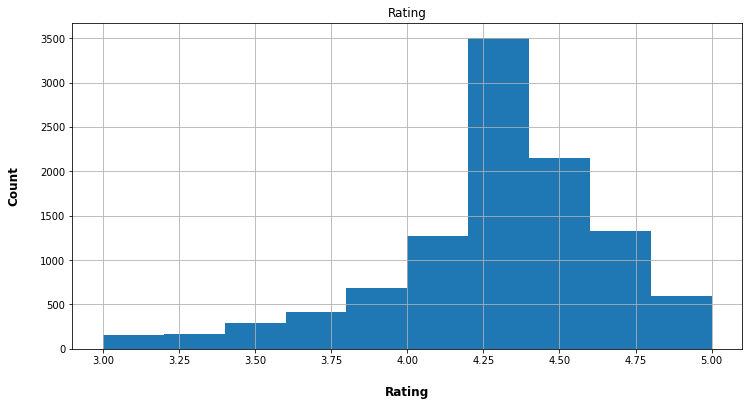

In [0]:
rating_histogram = google5.hist(column='Rating', figsize=(12,6))
chart, *rest = rating_histogram
for x in chart:
    x.set_xlabel("Rating", labelpad=20, weight='bold', size=12)
    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

We start out with finding the distribution of app ratings. You can see that it does not follow a traditional bell curve, but is rather heavily skewed to the right with a very short left tail.

In [0]:
# size_histogram = google5.hist(column='Size', figsize=(12,6))
#chart, *rest = size_histogram
#for x in chart:
#    x.set_xlabel("Size (mb)", labelpad=20, weight='bold', size=12)
#    x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

In [0]:
# reviews_histogram = google5.hist(column='Reviews', figsize=(12,6))
# chart, *rest = reviews_histogram
# for x in chart:
#     x.set_xlabel("Number of Reviews (in millions)", labelpad=20, weight='bold', size=12)
#     x.set_ylabel("Count", labelpad=20, weight='bold', size=12)

After running a similar histogram with reviews and app size, the vast majority of the rows are in the first cluster, so that it looks just like a single bar rather than an even histogram. The last two histograms will look much better if we got rid of all the outlier values, but based on the actual values, we couldn't find a fair cut off point that would be considered an outlier. In addition, we feel getting rid of those values may have a bad impact on the tests that we will be performing later on. Next, lets view the distributions of our categorical variables on our quantitative variables.

You can view the two histograms anyway by uncommenting the two code chunks above, but again, the vast majority of the data points are clustered onto one interval.

The follow code can be used to create overlapping histograms of rating based on category values. We will not compare every app genre because there are two many, but you can replace the values in the second set of square brackets and after the double equals sign to experiment for yourself. Here is an example we have provided. Category names include: ART_AND_DESIGN, AUTO_AND_VEHICLES, BEAUTY, BOOKS_AND_REFERENCE, BUSINESS, COMICS, COMMUNICATION, DATING, EDUCATION, ENTERTAINMENT, EVENTS, FAMILY, FINANCE, FOOD_AND_DRINK, GAME, HEALTH_AND_FITNESS, HOUSE_AND_HOME, LIBRARIES_AND_DEMO, LIFESTYLE, MAPS_AND_NAVIGATION, MEDICAL, NEWS_AND_MAGAZINES, PARENTING, PERSONALIZATION, PHOTOGRAPHY, PRODUCTIVITY, SHOPPING, SOCIAL, SPORTS, TOOLS, TRAVEL_AND_LOCAL, VIDEO_PLAYERS, WEATHER.

In our example, you can see the Arts&Design apps have a higher distribution of ratings, though the measurements done beforehand show there isn't statistical significance to this finding.

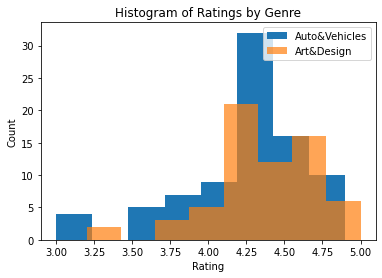

In [0]:
plt.hist(google5['Rating'][(google5['Category'] == 'AUTO_AND_VEHICLES')].dropna(), bins=8, label='Auto&Vehicles', histtype='stepfilled')#.show()
plt.hist(google5['Rating'][(google5['Category'] == 'ART_AND_DESIGN')].dropna(), bins=8, label='Art&Design', alpha=.7, histtype='stepfilled')#.show()
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Histogram of Ratings by Genre')
plt.legend()

This 2D categorical box plot again shows there is no statistical difference between free/paid apps and among content ratings.

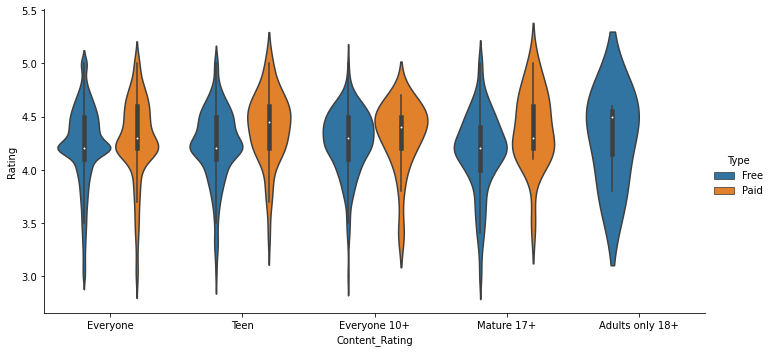

In [0]:
g = sns.catplot(x="Content_Rating", y="Rating", hue="Type",
               data=google5, kind="violin",
               height=5, aspect=2)

The following are grouped histograms that compare counts of each rating. The absolute counts of certain genres are very high, so it is not very easy to see the rest. Here, you can see which options of each categorical measure have a relativly flatter or normal distribution. We've found values with a higher sample size have a more normal distribution in general, though that was not always the case. Of course, that is to be expected.

*warning* they will take a long time to load

Text(0.5, 0.98, 'Category Segregation of Rating')

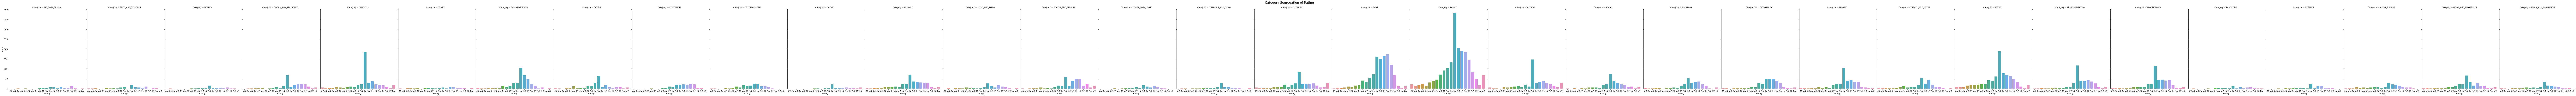

In [0]:
sns.factorplot('Rating', col='Category', data=google5, kind='count', size=7, aspect=.8)
plt.subplots_adjust(top=0.9)
plt.suptitle('Category Segregation of Rating', fontsize=16)

Text(0.5, 0.98, 'Installs Segregation of Rating')

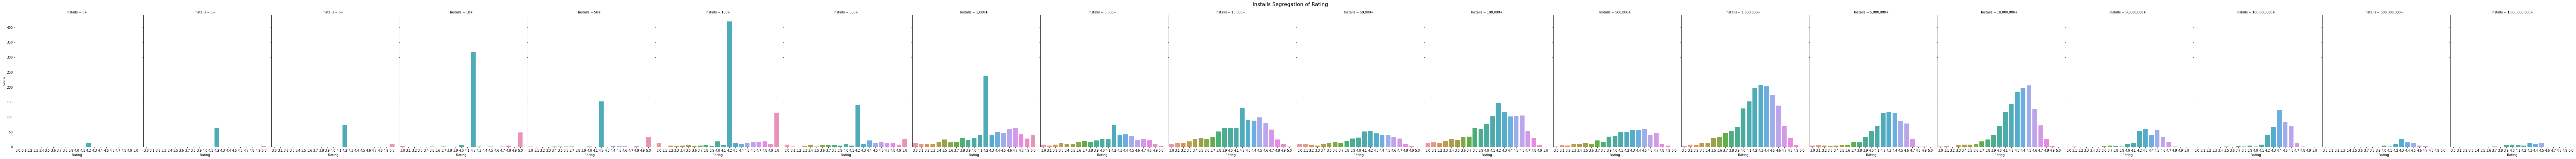

In [0]:
sns.factorplot('Rating', col='Installs', data=google5, kind='count', size=7, aspect=.8, 
               col_order=['0+', '1+', '5+', '10+', '50+', '100+', '500+', '1,000+',
                         '5,000+', '10,000+', '50,000+', '100,000+', '500,000+',
                         '1,000,000+', '5,000,000+', '10,000,000+', '50,000,000+',
                         '100,000,000+', '500,000,000+', '1,000,000,000+'])
plt.subplots_adjust(top=0.9)
plt.suptitle('Installs Segregation of Rating', fontsize=16)

Text(0.5, 0.98, 'Type Segregation of Rating')

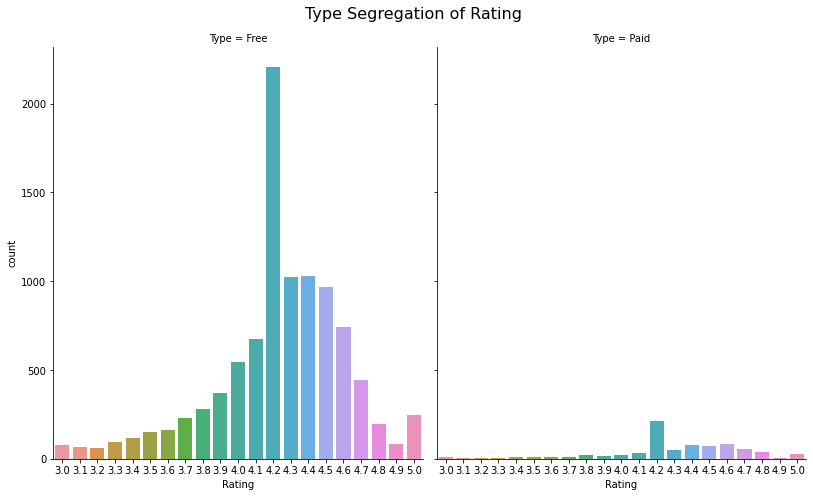

In [0]:
sns.factorplot('Rating', col='Type', data=google5, kind='count', size=7, aspect=.8)
plt.subplots_adjust(top=0.9)
plt.suptitle('Type Segregation of Rating', fontsize=16)

Text(0.5, 0.98, 'Content Rating Segregation of Rating')

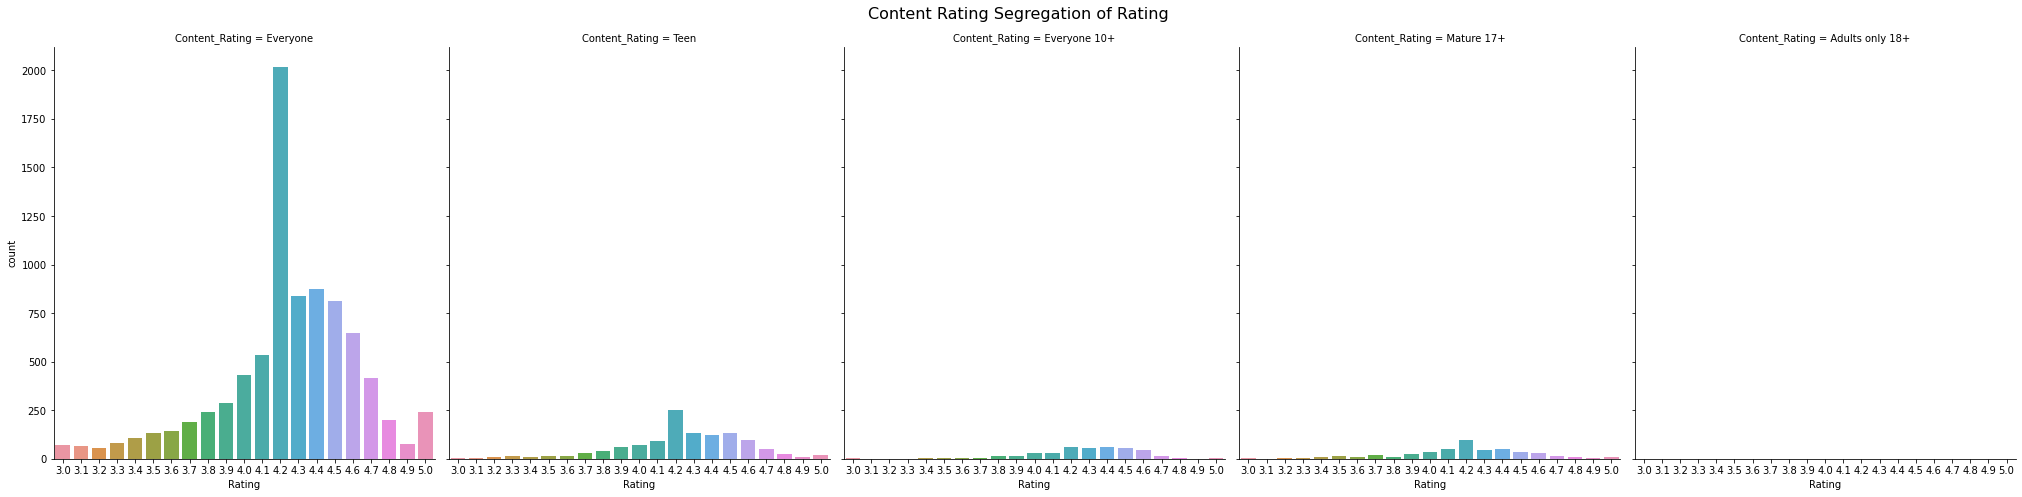

In [0]:
sns.factorplot('Rating', col='Content_Rating', data=google5, kind='count', size=7, aspect=.8)
plt.subplots_adjust(top=0.9)
plt.suptitle('Content Rating Segregation of Rating', fontsize=16)

In the end, it was hard to decide if an individual attribute contributed to rating more than the test. These visualizations as well as the measurements obtained from previous questions indicate that there isn't one.

Lets move on to the ML portion now.

### 3. Resuming Preprocessing using Sklearn

First, let's create the test and train sets.

The columns below are the features we will use to predict Rating. These are all of the columns from the cleaned dataset except for the application name, which is quite arbitrary since app names can be made-up words. Furthermore, we do not do any sentiment analysis in this project, so phrasing is irrelevant.

In [0]:
cols = ['Category','Installs','Content_Rating','Reviews','Size','Type']

In [0]:
google5.isna().sum()

App               0
Category          0
Rating            0
Reviews           0
Size              0
Installs          0
Type              0
Content_Rating    0
dtype: int64

In [0]:
X = google5[cols]
y = google5.Rating

Next, we will split X and y into training and testing sets, which will be called by our machine learning model.

In [0]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(7912, 6) (7912,)
(2638, 6) (2638,)


Category, Installs, Content_Rating, and Type are categorical features. It is not quite fitting to use Label Encoding for Category since the model may potentially find a relationship between categories based on their unique, mapped number even if the categories are totally different. Thus, we decided to use One-Hot Encoding for Category and the rest of the categorical features out of simplicity. 

Now we set up a column transformer using One-Hot Encoding for those features.


In [0]:
from sklearn.preprocessing import OneHotEncoder
#from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [0]:
ohe = OneHotEncoder(sparse=False,handle_unknown='ignore')
ct = make_column_transformer(
    (ohe, ['Category', 'Installs', 'Content_Rating','Type']),
    remainder = 'passthrough'
)

### 4. Training the Model

We will import Sklearn's `LinearRegression` model since our task is a supervised regression problem. We will also import `cross_val_score` to calculate the root mean squared error of our model on the entire dataset. Lastly, we import `make_pipeline` so that we can apply our column transformer to our data. 

In [0]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline

In [0]:
lnr = LinearRegression()
p1 = make_pipeline(ct, lnr)
score = cross_val_score(p1, X, y, cv=5, scoring='neg_root_mean_squared_error')
score.mean()

-0.3620067096325137

Root mean squared error (RMSE) is a function where a lower score is better than a higher score. As a result, `cross_val_score` takes in a score function of `neg_root_mean_squared_error`, in which the negative sign indicates a lower score is better. In actuality, the RMSE is simply the positive value of 0.3620.

Using the training set, we will train the pipeline containing the linear regression model.

In [0]:
p1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Installs',
                                                   'Content_Rating', 'Type'])],
                                   verbose=False)),
                ('linearregression',
                 

### 5. Testing

Now that the linear regression model is trained, we will use our test set to predict the rating of Google Play Store apps based on the following features: Category, Installs, Content_Rating, Reviews, Size, Type.

In [0]:
y_pred = p1.predict(X_test)

Let's analyze the test set's actual and predicted ratings. First, we'll look at basic statistics of the actual ratings.

In [0]:
# test set actual ratings
y_test.describe()

count    2638.000000
mean        4.243139
std         0.376011
min         3.000000
25%         4.100000
50%         4.200000
75%         4.500000
max         5.000000
Name: Rating, dtype: float64

Here we see that in the test set, there is a mean rating of 4.243139, min rating of 3.0, and max rating of 5.0. Now, let's look at the predicted ratings.

In [0]:
# test set predicted ratings
pd.Series(y_pred).describe()

count    2638.000000
mean        4.242721
std         0.096800
min         3.974749
25%         4.167861
50%         4.237339
75%         4.305708
max         4.737466
dtype: float64

Here we see that within the predicted ratings, there is a mean rating of 4.242721, which is very close to that of the actual ratings. The min rating is 3.974749, which is significantly higher than the min rating of the actual ratings. The max rating is 4.737466, which is not as high as the max rating of the actual ratings.

Below, we see a dataframe of an app's actual rating compared to its predicted rating.

In [0]:
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df['Residuals'] = comparison_df['Actual'] - comparison_df['Predicted']
comparison_df

,Actual,Predicted,Residuals
272,4.3,4.202107,0.097893
4384,3.8,4.218151,-0.418151
3368,4.3,4.370253,-0.070253
7073,4.2,4.313155,-0.113155
3867,3.5,4.114929,-0.614929
...,...,...,...
7433,5.0,4.458317,0.541683
9428,4.5,4.231677,0.268323
10349,5.0,4.450358,0.549642
5538,4.4,4.170098,0.229902


Let's plot the predicted rating against its residual to see how good of a fit our linear regression model is.

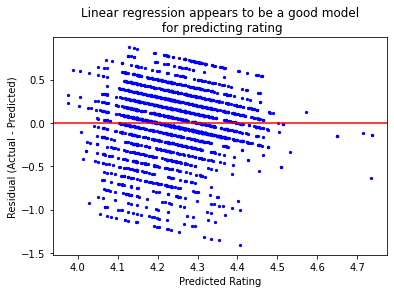

In [0]:
plt.scatter(comparison_df['Predicted'], comparison_df['Residuals'], color='blue',s=5)
plt.xlabel("Predicted Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Linear regression appears to be a good model\n" + 
          " for predicting rating")
plt.axhline(color='red')
plt.show()

Based on the residual plot above, the linear regression model is a fairly good model for predicting rating for three reasons:
1. The data points are fairly evenly distributed and tend to cluster around the middle of the plot (aside from some extreme outliers on the bottom of the plot)
2. The data points are fairly clustered around the zero line, indicating there are many more accurate predictions than inaccurate predictions.
3. There is no recognizable trend. If there were, the model could potentially be missing a higher-order variable.

### 6. Further Refinement of the Linear Regression Model

For this refinement, we will run a linear regression model on the data again but this time without the  `Type` feature.

In [0]:
google5['Type'].value_counts()
free_percentage = google5[google5['Type']=="Free"]['Type'].count()/google5['Type'].size
print("Percentage of apps that are free: " + str(free_percentage))

Percentage of apps that are free: 0.9262559241706161


As above, you can see that 92.63% of Google Play Store apps are free. As a result, this feature might be insignificant or even confusing for the model's training process. For the next linear regression model, we will remove the `Type` feature to see if the model will improve.

In [0]:
cols2 = ['Category','Installs','Content_Rating','Reviews','Size']
X2 = google5[cols2]
y2 = google5.Rating

Next, we will split X and y into training and testing sets, which will be called by our machine learning model.

In [0]:
# split X and y into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, random_state=0)

print(X_train2.shape, y_train2.shape)
print(X_test2.shape, y_test2.shape)

(7912, 5) (7912,)
(2638, 5) (2638,)


Now we set up a column transformer using OneHotEncoding for Category, Installs, and Content_Rating.

In [0]:
ohe2 = OneHotEncoder(sparse=False,handle_unknown='ignore')
ct2 = make_column_transformer(
    (ohe2, ['Category', 'Installs', 'Content_Rating']),
    remainder = 'passthrough'
)

Next, we will set up the pipeline to run our linear regression model using the column transformer.

In [0]:
lnr2 = LinearRegression()
p2 = make_pipeline(ct2, lnr2)
score2 = cross_val_score(p2, X2, y2, cv=5, scoring='neg_root_mean_squared_error')
score2.mean()

-0.3627144081681478

Since the RMSE is 0.3627, which is marginally higher than the RMSE of the original linear regression model (0.3620), this means that this linear regression line is slightly less accurate in predicting an app's rating. This confirms the hypothesis that `Type` is not a very significant feature for our model, but still, removing the `Type` feature actually causes a decrease in performance of our model.

### 7. Training New Models

Here, we will experiment with variations of the Linear Regression model to see which produces the lowest root mean squared error.

First, we will experiment with the Lasso model. This model, unlike the basic Linear Regression model, will penalize the model for the sum of the absolute value of its weights. The basic Linear Regression does not penalize weights, potentially leading to an overfitting of the model on the dataset.

In [0]:
from sklearn.linear_model import Lasso
las = Lasso()
p3 = make_pipeline(ct, las)
score3 = cross_val_score(p3, X, y, cv=5, scoring='neg_root_mean_squared_error')
score3.mean()

-0.36770997125566374

The RMSE is 0.3677, which is worse than the RMSE of 0.3620 from the basic Linear Regression model above in Section 4. Below, we try tuning the Lasso model by modifying the alpha parameter. The alpha parameter is a constant applied to the absolute value of its weights.

In [0]:
# lower alpha value
las1 = Lasso(alpha=0.1)
p4 = make_pipeline(ct, las1)
score4 = cross_val_score(p4, X, y, cv=5, scoring='neg_root_mean_squared_error')
score4.mean()

-0.367549761717825

In [0]:
# moderate alpha value
las2 = Lasso(alpha=2.0)
p5 = make_pipeline(ct, las2)
score5 = cross_val_score(p5, X, y, cv=5, scoring='neg_root_mean_squared_error')
score5.mean()

-0.3677216712778287

In [0]:
# very high alpha value
las3 = Lasso(alpha=10.0)
p6 = make_pipeline(ct, las3)
score6 = cross_val_score(p6, X, y, cv=5, scoring='neg_root_mean_squared_error')
score6.mean()

-0.3677215482850573

We see that with a lower alpha value, the RMSE becomes slightly lower, towards that of the basic Linear Regression model. This means that the basic Linear Regression model is preferred, which essentially has an alpha value of 0.

Second, we will experiment with the Ridge model. This model penalizes the model for the sum of squared value of its weights. 

In [0]:
from sklearn.linear_model import Ridge
rid = Ridge()
p7 = make_pipeline(ct, rid)
score7 = cross_val_score(p7, X, y, cv=5, scoring='neg_root_mean_squared_error')
score7.mean()

-0.36159426005240647

The RMSE is 0.3616, which is marginally better than the RMSE of the basic Linear Regression model. We will try tuning the Ridge model's alpha parameter, which is the constant applied to the squared value of its weights.

In [0]:
# lower alpha value
rid1 = Ridge(alpha=0.1)
p8 = make_pipeline(ct, rid1)
score8 = cross_val_score(p8, X, y, cv=5, scoring='neg_root_mean_squared_error')
score8.mean()

-0.36196040829427945

In [0]:
# moderate alpha value
rid2 = Ridge(alpha=2.0)
p9 = make_pipeline(ct, rid2)
score9 = cross_val_score(p9, X, y, cv=5, scoring='neg_root_mean_squared_error')
score9.mean()

-0.3612703364666974

In [0]:
# very high alpha value
rid3 = Ridge(alpha=10.0)
p10 = make_pipeline(ct, rid3)
score10 = cross_val_score(p10, X, y, cv=5, scoring='neg_root_mean_squared_error')
score10.mean()

-0.3600544826766253

We see that when we use a very high alpha value, we achieve a RMSE of 0.3601. We are able to improve the RMSE to be better than the basic Linear Regression model.

### 8. Predicting Rating with the new Ridge model

Let's try predicting rating with the Ridge model of an alpha value of 10.0.

In [0]:
p10.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='passthrough',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['Category', 'Installs',
                                                   'Content_Rating', 'Type'])],
                                   verbose=False)),
                ('ridge',
                 Ridge(alpha

Below, we see a dataframe of an app's actual rating compared to its predicted rating.

In [0]:
y_pred10 = p10.predict(X_test)
comparison_df1 = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred10})
comparison_df1['Residuals'] = comparison_df1['Actual'] - comparison_df1['Predicted']
comparison_df1

,Actual,Predicted,Residuals
272,4.3,4.203189,0.096811
4384,3.8,4.221516,-0.421516
3368,4.3,4.367520,-0.067520
7073,4.2,4.309283,-0.109283
3867,3.5,4.126899,-0.626899
...,...,...,...
7433,5.0,4.452726,0.547274
9428,4.5,4.231336,0.268664
10349,5.0,4.441432,0.558568
5538,4.4,4.174033,0.225967


Let's plot the predicted rating against its residual with a zero line to see how good of a fit our linear regression model is.

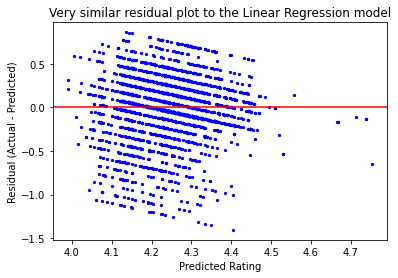

In [0]:
plt.scatter(comparison_df1['Predicted'], comparison_df1['Residuals'], color='blue',s=5)
plt.xlabel("Predicted Rating")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Very similar residual plot to the Linear Regression model")
plt.axhline(color='red')
plt.show()

Given that the Ridge model with an alpha value of 10.0 produces a slightly better but still very similar RMSE to the basic Linear Regression model, it is expected that its residual plot should also be very similar.

### 9. Reflection

For this project, our feature selection was as follows: Category, Number of Installs, Content Audience Rating, Number of Reviews, Size of App, Free or Paid.

A significant portion of this project consisted of data cleaning. To make sure that the test and train sets did not have null values, we replaced null values with the mean of its column. Furthermore, feature engineering was an important aspect of this project as well. Of the above features that we cared about, Category, Content Audience Rating, and Free or Paid were categorical features. This necessitated utilizing One-Hot Encoding to transform these features into boolean 1's and 0's.

Through EDA, one of the difficulties of accurately predicting a phone app's rating using our feature selection that we found was that rating is not strongly correlated to the other quantitative attributes. As demonstrated by the Pearson Coefficient, the Number of Installs, Number of Reviews, and Size of App were extremely weak indicators of an app's rating.

Although all the features (except for the rating itself) are proxies for determining the rating, some features could naturally be more telling than others. For example, if the dataset included the written review that came with the rating, we could explore sentiment analysis and how it might affect rating. Perhaps another step that we could take for future analysis is further experimenting with the scaling of features to normalize the dataset even more.